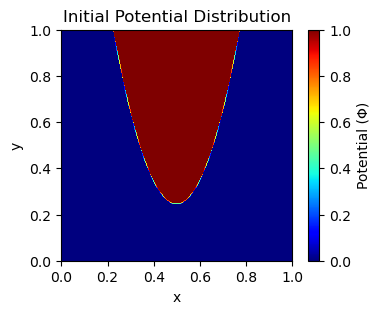

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x_tip = 0.5
y_tip = 0.25
R = 0.05
N = 256

# fn returns the y-pos (in actual values) corresponding to the y-value in the parabolic setup.
# takes into account the bounded nature of the problem [0,1]
def y(x):
    y_actual = (x - x_tip)**2 / (2 * R) + y_tip
    
    if y_actual<1:
        return y_actual
    else: # if value obtained from the parabolic equation is higher, then set it to one (as the Dirichlet condition applies to the y=1 boundary)
        return 1

# this fn simply computes the 2d residuum integral for any given spatial grid
# implementation of the general central difference grid for the calculations on the inside of the grid
# for the boundary points, we use 3 point forward and backward formulae
# calculations of the stencil weights are not shown here, refer to the derivation given additionally
def Residuum(phi):
    residuum = 0 # accumulator
    
    for i in range(0, N):
        x_pos = 0 + i*h
        y_pos = y(x_pos)
    
        y_pos_index = int(y_pos/h)
        
        # setting up this loop to automatically exclude the top and bottom horizontal boundaries (y=0 and y=1)
        # Dirichlet BC for these
        # Additionally, this saves us the hassle to implement end point schemes along the y-direction
        
        """
        PROBLEM !!!
        
        Issue: 
        Using the entire grid for the computation here, as the integral is defined as such
        Some compute load can be saved by skipping over the parts where the phi=1, as their residuum terms become 0
        But, when this is run, the residuum seems to plateau around 1e4, and stays that way.
        
        Works:
        When the potential with the constant part is excluded from the residuum range, this works just fine.
        """
        for j in range(1, y_pos_index): 
            if i == 0: # for x=0 bound
                # central in y-dir + forward stencil in x-dir
                integrand = ( (Phi[i, j-1] - 2*Phi[i, j] + Phi[i, j+1]) + (Phi[i,j] - 2*Phi[i+1, j] + Phi[i+2, j]) )/ h**2
                
            elif i == N: # for x=1 bound
                # central in y-dir + backward stencil in x-dir
                integrand = ( (Phi[i, j-1] - 2*Phi[i, j] + Phi[i, j+1]) + (Phi[i-2,j] - 2*Phi[i-1, j] + Phi[i, j]) )/ h**2
                
            else: 
                integrand = ( Phi[i-1, j] + Phi[i, j-1] - 4*Phi[i, j] + Phi[i+1, j] + Phi[i, j+1] ) / h**2
            
            residuum = residuum + (integrand**2) * h**2 # discrete summation step for the integral
    return residuum


# Setting up the problem - INITIAL STATE OF GRID 
h = 1/N    
Phi = np.zeros((N+1, N+1))
   
# filling up the values for the initial state phi 
for i in range(0, N+1):
    x_pos = 0 + i*h
    y_pos = y(x_pos)
    
    y_pos_index = int(y_pos/h)
    # y_pos_index2 = np.ceil(y_pos/h).astype(int) # both yield more or less similar results
    # print(y_pos_index, y_pos_index2)

    # once we get the index beyond 
    for j in range(y_pos_index, N+1):
        Phi[i, j] = 1
        
Phi0 = Phi.copy() # used for later calculations, DELETE AFTER PROGRAM RUNNING AS DESIRED
       
# Visualization of the initial grid
plt.figure(figsize=(4, 3))
plt.imshow(Phi.T, origin='lower', extent=[0, 1, 0, 1], cmap='jet')
plt.colorbar(label='Potential (Φ)')
plt.title('Initial Potential Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
"""Implementation of the general GS relaxation with the relaxation parameter 'p'
For the purposes of the question, residuum tracking and termination conditions have been added"""
def GaussSeidel_and_Residuums(p,tol, max_iter):
    counter = 0 # counter for iterations
    
    residuums = [] # accumulator of the grid residuum for each iteration
    counters = [] # to simply append the counter, later used for plotting the residuums for tally
    
    while True:
        
        counters.append(counter)
        residuums.append(Residuum(Phi))
        
        if residuums[-1] < tol:
            break
        if counter == max_iter:
            break
        
        # only updating the internal points using row wise GS implementation
        # for the vertical boundaries, von Neumann condition is enforced after the update
        for i in range(1, N):
            y_pos = y(i*h)
            y_pos_index = int(y_pos/h)
            
            # note that the GS implementation must happen right until the index where the potential becomes = 1
            # this means the values of the phi = 1 must be involved in the computations of the GS iteration to develop the gradient properly
            # if the y_pos_index is reduced by 1, the plot will take a very different form (gradients of phi = 0.8, 0.6, etc disappear)
            for j in range(1, y_pos_index):
                Phi_current = Phi[i][j]
                term = 0.25*(Phi[i-1, j] + Phi[i, j-1] + Phi[i+1, j] + Phi[i, j+1])
                Phi[i, j] = p * term + (1-p)*Phi_current
            
            
        # Enforce Neumann boundary conditions (left and right boundaries), after each iteration
        Phi[0, :] = Phi[1, :]
        Phi[-1, :] = Phi[-2, :]
        
        counter  = counter + 1
        
    # Visualization of the relaxed potential
    plt.figure(figsize=(8, 6))
    plt.imshow(Phi.T, origin='lower', extent=[0, 1, 0, 1], cmap='jet')
    plt.colorbar(label='Potential (Φ)')
    plt.title(f'Potential Distribution After {counter} GS Iterations, SOR p = {p}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()    
    
    return counters, residuums


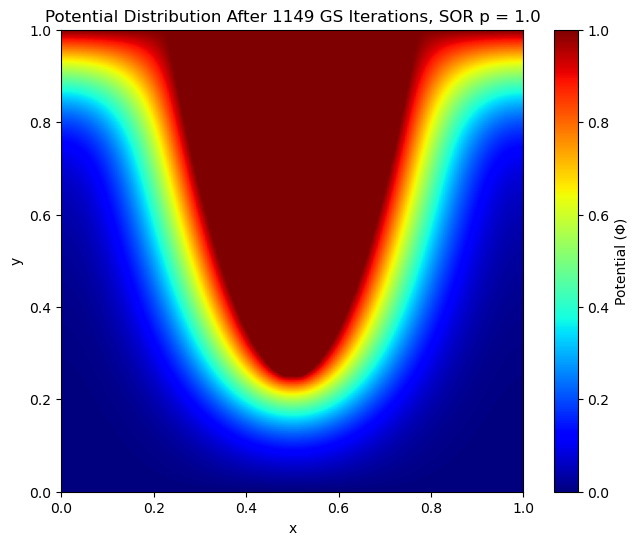

In [9]:
# parameters as given in the question.
p=1.00
tol=1e-4
max_iter=1149 # run limit if convergence fails
counter_arr, residuum_arr = GaussSeidel_and_Residuums(p, tol, max_iter)

# save residuum-arr locally for plots later
np.save("residuum-arr-gs.npy", residuum_arr)

Text(0, 0.5, 'Residuum')

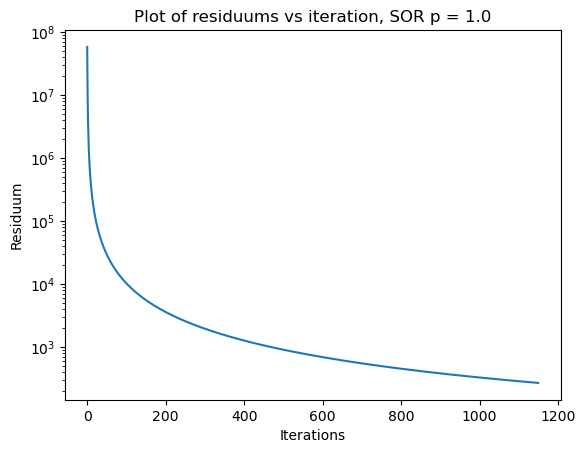

In [10]:

plt.plot(counter_arr, residuum_arr)
plt.yscale("log")
plt.title(f"Plot of residuums vs iteration, SOR p = {p}")
plt.xlabel("Iterations")
plt.ylabel("Residuum")